In [1]:
include("jl/omega.jl")
include("jl/HSBM.jl")
include("jl/objectives.jl")
include("jl/inference.jl")

using Plots

In [12]:
function read_hypergraph_data(dataname::String)
    labels = Int64[]
    open("data/$dataname/node-labels-$dataname.txt") do f
        for line in eachline(f)
            push!(labels, parse(Int64, line))
        end
    end
    n = length(labels)

    E = Dict{Integer, Dict}()
    open("data/$dataname/hyperedges-$dataname.txt") do f
        for line in eachline(f)
            edge = [parse(Int64, v) for v in split(line, ',')]
            sort!(edge)
            sz = length(edge)
            if !haskey(E, sz)
                E[sz] = Dict{}()
            end
            E[sz][edge] = 1
        end
    end
    
    D = zeros(Int64, n)
    for (sz, edges) in E
        for (e, _) in edges
            D[e] .+= 1
        end
    end
    
    N = 1:n
    
    return hypergraph(N, E, D), labels
end

read_hypergraph_data (generic function with 1 method)

In [13]:
# size 2/3 hyperedges in walmart-trips data
H, labels = read_hypergraph_data("walmart-trips-restricted")

(hypergraph
  N: Array{Int64}((5669,)) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669]
  E: Dict{Int64,Dict}
  D: Array{Int64}((5669,)) [9, 1, 1, 12, 1, 4, 1, 11, 5, 10  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
, [11, 7, 7, 11, 7, 11, 11, 7, 7, 11  …  1, 3, 6, 10, 7, 8, 5, 7, 7, 2])

In [14]:
# Example with fixed omega

function ω(p, α)
    if p == [1, 1]; return 1e-4; end
    if p == [2, 1]; return 1e-4; end
    if p == [1, 1, 1]; return 1e-4; end
    return 1e-5
end

α0 = 0

Ω = Ω = buildΩ(ω, α0, 3)
L(H, labels, Ω;α=α0)

(-4.23927742249333257929719553889165765091229243211046195938251912593841552734375e+08, 33168.20391985842, 6842.742789399427)

In [15]:
function construct_Ω(a, b, c)
    Ω_dict = Dict{Array{Int64,1}, Float64}()
    for k = 1:3, p in partitions(k)
        Ω_dict[p] = 1e-5
        if p == [1, 1];    Ω_dict[p] = a; end
        if p == [2, 1];    Ω_dict[p] = b; end
        if p == [1, 1, 1]; Ω_dict[p] = c; end
    end
    return ΩFromDict(Ω_dict)
end

construct_Ω (generic function with 1 method)

In [16]:
function construct_Ω(a, b, c)
    function ω(p, α)
        if p == [1, 1]; return a; end
        if p == [2, 1]; return b; end
        if p == [1, 1, 1]; return c; end
        return 1e-5
    end
    return buildΩ(ω, α0, 3)
end

construct_Ω (generic function with 1 method)

In [25]:
a = 1e-4
b = 1e-4
cs = 1e-4:1e-4:1e-2
lls = [L(H, labels, construct_Ω(a, b, c);α=α0)[1] for c in cs];

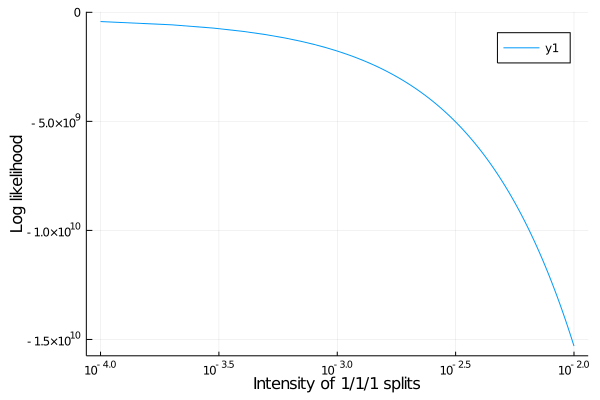

In [30]:
plot(cs, lls, xaxis=:log)

# semilogx(cs, lls)
xlabel!("Intensity of 1/1/1 splits")
ylabel!("Log likelihood")


In [50]:
Ω̂ = estimateΩEmpirically(H, labels;min_val=0)
Dict(p => Ω̂(p;α=1, mode="partition") for k = 1:3 for p in partitions(k))

Dict{Array{Int64,1},Float64} with 6 entries:
  [3]       => 7.83001e-10
  [1, 1]    => 1.69537e-5
  [1]       => 0.0
  [1, 1, 1] => 2.46188e-11
  [2]       => 3.41552e-5
  [2, 1]    => 1.48453e-10

In [53]:
H1, labels1 = read_hypergraph_data("walmart-trips")
Ω̂ = estimateΩEmpirically(H1, labels1;min_val=0)
Dict(p => Ω̂(p;α=1, mode="partition") for k = 1:6 for p in partitions(k))

Dict{Array{Int64,1},Float64} with 29 entries:
  [2, 2, 1]          => 3.04173e-25
  [4, 1, 1]          => 2.50917e-31
  [3, 3]             => 2.06891e-30
  [6]                => 3.87572e-30
  [1, 1, 1, 1]       => 4.89513e-20
  [3, 2]             => 6.47488e-25
  [4, 2]             => 1.31216e-30
  [2, 2]             => 3.19452e-19
  [3, 2, 1]          => 5.15817e-31
  [3]                => 2.60892e-13
  [1, 1]             => 3.90786e-8
  [1, 1, 1]          => 4.30232e-14
  [2]                => 1.06863e-7
  [2, 1, 1]          => 9.43081e-20
  [2, 1]             => 9.62975e-14
  [3, 1, 1, 1]       => 1.35044e-31
  [2, 1, 1, 1, 1]    => 1.30224e-31
  [4, 1]             => 3.27013e-25
  [2, 2, 2]          => 8.17165e-31
  [4]                => 6.30033e-19
  [1]                => 0.0
  [5, 1]             => 7.10365e-31
  [5]                => 1.51638e-24
  [1, 1, 1, 1, 1, 1] => 3.30202e-32
  [2, 1, 1, 1]       => 1.08652e-25
  ⋮                  => ⋮

In [55]:
H2, labels2 = read_hypergraph_data("contact-primary-school")
Ω̂ = estimateΩEmpirically(H2, labels2;min_val=0)
Dict(p => Ω̂(p;α=1,mode="partition") for k = 1:5 for p in partitions(k))

Dict{Array{Int64,1},Float64} with 18 entries:
  [2, 2, 1]       => 0.0
  [1, 1, 1, 1]    => 2.63793e-17
  [3, 2]          => 1.21079e-20
  [2, 2]          => 1.62774e-15
  [3]             => 8.0744e-9
  [1, 1]          => 6.11627e-6
  [1, 1, 1]       => 1.9784e-11
  [2]             => 2.71563e-5
  [2, 1, 1]       => 1.44976e-16
  [2, 1]          => 2.26271e-10
  [4, 1]          => 7.27548e-21
  [4]             => 1.5675e-13
  [1]             => 0.0
  [5]             => 2.86983e-19
  [2, 1, 1, 1]    => 7.33995e-23
  [3, 1, 1]       => 1.48953e-21
  [1, 1, 1, 1, 1] => 0.0
  [3, 1]          => 2.54386e-15